In [1]:
!rm -r ML

In [2]:
!git clone https://github.com/fuat-arslan/ML.git

Cloning into 'ML'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 268 (delta 49), reused 0 (delta 0), pack-reused 163
Receiving objects: 100% (268/268), 6.09 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [3]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import pandas_profiling 
from pandas_profiling import ProfileReport

In [5]:
data = pd.read_csv("/content/ML/raw_data/archive/sdss-IV-dr16-70k.csv")

In [6]:
# profile = ProfileReport(data)
# profile

# PREPROCESSING

In [7]:
%cd ML

/content/ML


In [8]:
from Preprocess.Preprocess import pd_np_Converter, OutlierRemoval, MinMax, Encoder
from Preprocess.Feauture_Engineering import PCA

In [9]:
# rerun is constant, objid is not a feature
data = data.drop(columns=["rerun", "objid"])
# move class to end of data
label = data.pop("class")
data["class"] = label
data.head()

,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,run,camcol,field,redshift,plate,mjd,fiberid,class
0,339.63895,-0.025366,24.16277,22.12683,20.49114,19.84393,19.39186,4207,3,235,0.330663,674,52201,119,GALAXY
1,339.14540,-1.176621,24.14103,25.11438,21.40677,19.78998,22.82654,3388,1,180,-0.000051,674,52201,121,STAR
2,339.09143,-1.226396,22.52415,21.39598,20.74594,20.26970,19.80169,3388,1,180,0.185197,674,52201,122,GALAXY
3,339.18984,-1.083550,18.44084,17.32474,16.90879,16.75017,16.68101,3388,1,180,-0.000061,674,52201,123,STAR
4,339.21747,-1.248835,19.55987,19.37768,19.28220,19.27481,19.10290,3388,1,181,0.863151,674,52201,124,QSO


In [10]:
# convert data to numpy 
converter = pd_np_Converter(data)
data_np = converter.to_nup()
X = data_np[:, :-1].astype(float)
Y = data_np[:, -1].reshape(-1,1)
X, Y

(array([[ 3.3963895e+02, -2.5366490e-02,  2.4162770e+01, ...,
          6.7400000e+02,  5.2201000e+04,  1.1900000e+02],
        [ 3.3914540e+02, -1.1766212e+00,  2.4141030e+01, ...,
          6.7400000e+02,  5.2201000e+04,  1.2100000e+02],
        [ 3.3909143e+02, -1.2263956e+00,  2.2524150e+01, ...,
          6.7400000e+02,  5.2201000e+04,  1.2200000e+02],
        ...,
        [ 2.3794580e+02, -1.0211284e+00,  2.3042780e+01, ...,
          3.4300000e+02,  5.1692000e+04,  2.8600000e+02],
        [ 2.3795178e+02, -1.0445313e+00,  2.1985720e+01, ...,
          3.4300000e+02,  5.1692000e+04,  2.8700000e+02],
        [ 2.3802744e+02, -8.9427257e-01,  1.9447550e+01, ...,
          3.4300000e+02,  5.1692000e+04,  2.8800000e+02]]), array([['GALAXY'],
        ['STAR'],
        ['GALAXY'],
        ...,
        ['GALAXY'],
        ['GALAXY'],
        ['QSO']], dtype=object))

In [11]:
# then apply outlier removal and standard normalized
OutRemove = OutlierRemoval(X, Y, 3) # 3 denotes threshold value
X_clean, Y_clean = OutRemove.fast()
X_clean.shape, Y_clean.shape

((66329, 14), (66329, 1))

In [12]:
# since psf_Mag's are highly linearly correlated, they are decorrelated using PCA
# we are not decreasing the dimension!!
pca = PCA()
decorrelated_psf = pca.fast(X_clean[:, 2:7], 5)
decorrelated_psf

array([[-0.01095209, -0.00501874, -0.00076389, -0.00051687, -0.00017521],
       [-0.02288711, -0.00089556,  0.00095841, -0.01047953,  0.00600617],
       [-0.00901848,  0.00166024, -0.00029926,  0.00044585, -0.00022209],
       ...,
       [-0.00487142, -0.00426251,  0.00098315, -0.00143684, -0.00023805],
       [ 0.00376348, -0.00290885, -0.00032283,  0.00010291, -0.00011273],
       [ 0.0110536 ,  0.00388839,  0.00174748, -0.00012445, -0.00072617]])

In [13]:
# map decorrleted_psf to -3,3
mapper = MinMax(low = -3, high = 3)
psf = mapper.fast(decorrelated_psf)
psf

array([[-1.00659912, -0.44134628, -0.67973026,  0.03733094, -0.39212334],
       [-1.74732434,  0.02172388, -0.43924667, -1.29560489,  0.30016497],
       [-0.8865931 ,  0.30876363, -0.6148543 ,  0.16613592, -0.39737398],
       ...,
       [-0.6292132 , -0.35641448, -0.43579097, -0.08575483, -0.39916092],
       [-0.09330395, -0.20438616, -0.61814465,  0.12025261, -0.38512614],
       [ 0.35914438,  0.55900553, -0.32906811,  0.08983296, -0.4538284 ]])

In [14]:
# change old values by new decorrelated values
X_clean[:, 2:7] = psf

In [15]:
# label encoder
encode = Encoder()
Y = encode.fast(Y_clean)
Y

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

# Neural Network Model

In [16]:
from Models.NeuralNetwork.Layers import Dense
from Models.NeuralNetwork.Optimizer import Optimizer
from Models.NeuralNetwork.Trainer import NeuralNetwork
from Metrics.Metrics import Evaluator, kFold

Cost after epoch 0: 0.170402
Cost after epoch 10: 0.084535
Cost after epoch 20: 0.077402
Cost after epoch 30: 0.074975
Cost after epoch 40: 0.073297
Cost after epoch 50: 0.070538


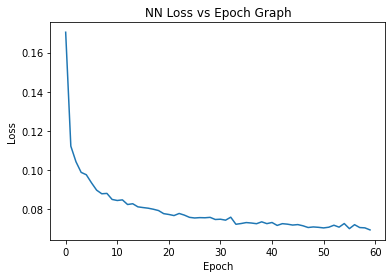

In [18]:
# L Layer Neural Network Build
layers = [Dense(14, 32), Dense(32, 8), Dense(8, 3, activation = "softmax")]
model_NN = NeuralNetwork(layers, "CrossEntopy")
adam = Optimizer("adam", 0.01, None, 0.9, 0.99)

model_NN.learn(X_clean, Y, optimizer = adam, max_epoch = 60, batch_size = 64)

Accuracy:  0.98


(0.9769180901264907, array([[0.99187042, 0.97712942, 0.98444474],
        [0.85382685, 0.95219216, 0.90033076],
        [0.96627826, 0.98443396, 0.97527162]]))

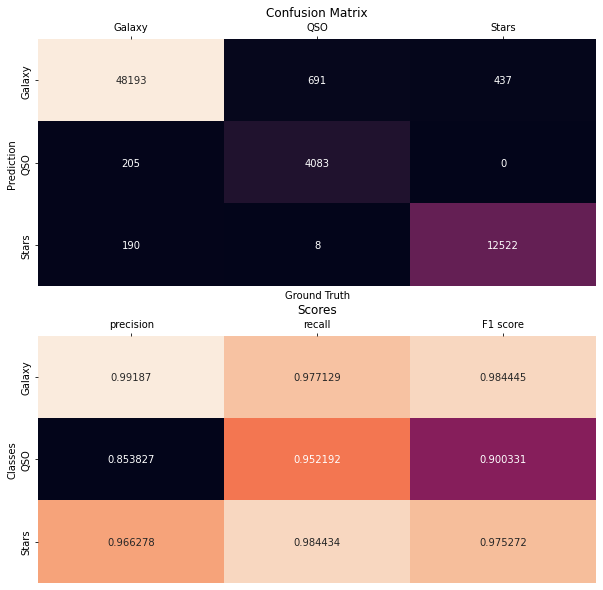

In [19]:
# predict, acc, confusion_matrix calculate
soft_out = model_NN.predict(X_clean)
pred = np.argmax(soft_out, axis = 0)
true_label = np.argmax(Y, axis = 1)
label_dict = {"Galaxy": 0, "QSO": 1, "Stars": 2}
score = Evaluator(pred, true_label, label_dict)
score.scores()

Cost after epoch 0: 0.184766
Cost after epoch 10: 0.091209
Cost after epoch 20: 0.080477
Cost after epoch 30: 0.076698
Cost after epoch 40: 0.073706
Accuracy of fold 1 : % 97.7566


Cost after epoch 0: 0.187106
Cost after epoch 10: 0.089957
Cost after epoch 20: 0.081723
Cost after epoch 30: 0.077039
Cost after epoch 40: 0.074876
Accuracy of fold 2 : % 97.6932


Cost after epoch 0: 0.176011
Cost after epoch 10: 0.084098
Cost after epoch 20: 0.076863
Cost after epoch 30: 0.073361
Cost after epoch 40: 0.071744
Accuracy of fold 3 : % 97.2817


Average loss: 0.0872


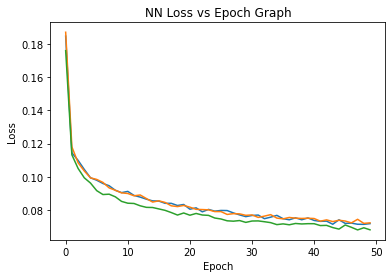

In [20]:
cv = kFold()

structure = [Dense(14, 32), Dense(32, 8), Dense(8, 3, activation = "softmax")]
cv_NN = NeuralNetwork(structure, "CrossEntopy")
adam = Optimizer("adam", 0.01, None, 0.9, 0.99)

cv_eval = cv.eval(cv_NN, X_clean, Y, "CrossEntropy", 3, adam, 50, 64)

In [17]:
from Preprocess.Feauture_Engineering import BackwardElimination

In [18]:
build = [Dense(14, 32), Dense(32, 8), Dense(8, 3, activation = "softmax")]
model_nn = NeuralNetwork(build, "CrossEntopy")
adam = Optimizer("adam", 0.01, None, 0.9, 0.99)

Cost after epoch 0: 0.194737
Cost after epoch 10: 0.086541
Cost after epoch 20: 0.079501

 Accuracy  : % 97.8592

 The feature of ra is removed
Cost after epoch 0: 0.670193
Cost after epoch 10: 0.437970
Cost after epoch 20: 0.428230

 Accuracy  : % 97.829



 The feature of dec is removed
Cost after epoch 0: 0.523256
Cost after epoch 10: 0.352124
Cost after epoch 20: 0.369337

 Accuracy  : % 97.9149



 The feature of psfMag_u is removed
Cost after epoch 0: 0.668199
Cost after epoch 10: 0.585461
Cost after epoch 20: 0.527105

 Accuracy  : % 97.1415



 The feature of psfMag_g is removed
Cost after epoch 0: 1.153405
Cost after epoch 10: 0.525836
Cost after epoch 20: 0.512217

 Accuracy  : % 97.532



 The feature of psfMag_r is removed
Cost after epoch 0: 7.227977
Cost after epoch 10: 7.216693
Cost after epoch 20: 7.180912

 Accuracy  : % 78.9398



 The feature of psfMag_i is removed
Cost after epoch 0: 0.634722
Cost after epoch 10: 0.407741
Cost after epoch 20: 0.385286

 Accuracy  : 

KeyboardInterrupt: ignored

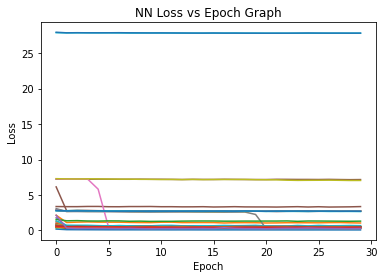

In [19]:
Backward = BackwardElimination(3, 0, model_nn, converter.columns)
eliminated_data = Backward.fast(X_clean, Y, adam, 30, 64)

In [22]:
eliminated_data.shape

(66329, 14)

In [ ]:
build2 = [Dense(14, 32), Dense(32, 8), Dense(8, 3, activation = "softmax")]
NN = NeuralNetwork(build2, "CrossEntopy")
adam = Optimizer("adam", 0.01, None, 0.9, 0.99)

NN.learn(eliminated_data, Y, optimizer = adam, max_epoch = 60, batch_size = 64)